In [11]:
%pip install deap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
df = pd.read_csv('./data/processed_mrna_zscore.csv')

In [2]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

Select 500 features by filtering methods.

In [3]:
file_path = './top_features_rf_500.txt'

with open(file_path, 'r') as file:
    content = file.read().splitlines()

top500 = content

The search space is now in 500 top features selected by a filtering methods

In [4]:
sel_X = X[top500]

In [5]:
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import StratifiedKFold
# Assuming X and y are your feature matrix and target variable
# X is a pandas DataFrame with 1800 samples and 500 features
# y is a pandas Series with the corresponding labels

# DEAP initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual (binary representation of features)
def create_individual():
    n = sel_X.shape[1]
    num_ones = 5
    return random.sample([1]*num_ones + [0]*(n-num_ones), n)

# Function to evaluate the fitness of an individual
def evaluate_individual(individual):
    selected_features = [i for i, gene in enumerate(individual) if gene]
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals

    
    clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs=-1)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index, selected_features], sel_X.iloc[test_index, selected_features]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

# DEAP Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)



In [6]:
population_size = 50
generations = 20
crossover_rate = 0.8
mutation_rate = 0.1

# Collect fitness values for plotting
max_fitness_values = []

population = toolbox.population(n=population_size)

for gen in range(generations):
    # Evaluate the entire population
    fitness_values = list(toolbox.map(toolbox.evaluate, population))
    
    # Update the fitness values
    for ind, fit in zip(population, fitness_values):
        ind.fitness.values = fit
    
    # Select the next generation individuals
    offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
    
    # Evaluate offspring
    fitness_values = list(toolbox.map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitness_values):
        ind.fitness.values = fit
    
    # Select the next generation from offspring
    population = toolbox.select(offspring + population, k=population_size)
    
    # Collect the highest fitness value for this generation
    max_fitness = np.array([ind.fitness.values[0] for ind in population]).mean()
    max_fitness_values.append(max_fitness)

    # Print the highest fitness value for this generation
    print(f"Generation {gen + 1}: Mean Fitness = {max_fitness}")

Generation 1: Mean Fitness = 0.858534652439656
Generation 2: Mean Fitness = 0.8606547705376566
Generation 3: Mean Fitness = 0.8621899409509998
Generation 4: Mean Fitness = 0.863410908525847
Generation 5: Mean Fitness = 0.8644069201284578
Generation 6: Mean Fitness = 0.8653133740805968
Generation 7: Mean Fitness = 0.8660360509686109
Generation 8: Mean Fitness = 0.8674710970682692
Generation 9: Mean Fitness = 0.8676339997928108
Generation 10: Mean Fitness = 0.8676746089298666
Generation 11: Mean Fitness = 0.8676747125246042
Generation 12: Mean Fitness = 0.867735574432819
Generation 13: Mean Fitness = 0.8677966435305089
Generation 14: Mean Fitness = 0.8680404537449499
Generation 15: Mean Fitness = 0.8683038433647572
Generation 16: Mean Fitness = 0.8685168859421941
Generation 17: Mean Fitness = 0.8685477053765668
Generation 18: Mean Fitness = 0.8687827618356988
Generation 19: Mean Fitness = 0.8689878794157258
Generation 20: Mean Fitness = 0.8691109499637419


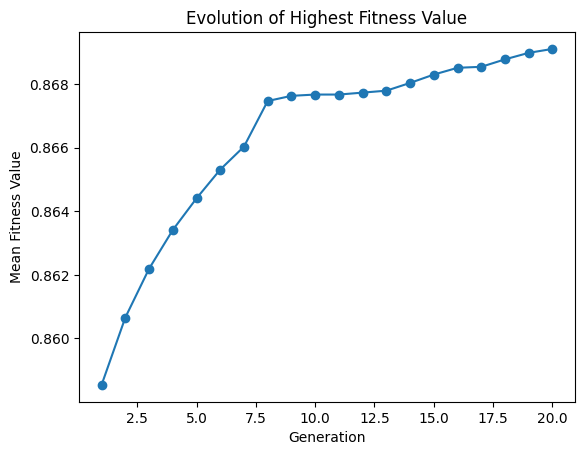

Best individual: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
# Plotting
plt.plot(range(1, generations + 1), max_fitness_values, marker='o')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness Value')
plt.title('Evolution of Highest Fitness Value')
plt.show()

# Get the best individual from the final population
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i, gene in enumerate(best_individual) if gene]

print("Best individual:", best_individual)
print("Selected features:", selected_features)

In [8]:
genetic_features = X.columns[selected_features]

In [9]:
genetic_features

Index(['ATP6V1C2', 'FAM174C', 'HERC2P9', 'PDIA6', 'RASSF4', 'DNAJC9', 'FAM69B',
       'KCNA6', 'ENO2', 'CCZ1B', 'LRATD2', 'PTDSS1', 'DRD5', 'KCNJ8', 'PSMD3',
       'KCNJ4', 'ZFAND2B', 'NUCB2', 'PLOD1', 'DENND1A', 'NAT14', 'UGT3A1',
       'TCL1A', 'ETV4', 'AGGF1', 'CACTIN', 'KRTAP9-4', 'CLCNKB', 'OR4C11',
       'BTN2A2', 'CUL1', 'RABAC1', 'UBA5', 'SYT5', 'ONECUT2', 'HSP90AB3P',
       'BTG4', 'CHST11', 'ZNF890P', 'TCEA1', 'C11orf40', 'CD99P1', 'MAPK14',
       'NPL', 'TSPAN4'],
      dtype='object')

In [10]:
from sklearn.ensemble import RandomForestClassifier
from k_fold import k_fold

k_fold(classifier=RandomForestClassifier(n_estimators=1000, n_jobs=-1), 
                X=X[genetic_features], y=y)

Fold 1: 0.8527918781725888
Fold 2: 0.8578680203045685
Fold 3: 0.8527918781725888
Fold 4: 0.8578680203045685
Fold 5: 0.8316326530612245
Fold 6: 0.8622448979591837
Fold 7: 0.8418367346938775
Fold 8: 0.8571428571428571
Fold 9: 0.8622448979591837
Fold 10: 0.8571428571428571
Average Weighted Accuracy: 0.8533564694913498


0.8533564694913498

Compare with 15 features selected by random forest, the smaller set of features found by genetic algorithm perform better

In [11]:
file_path = './top_features_rf_15.txt'

with open(file_path, 'r') as file:
    content = file.read().splitlines()

top15 = content

In [12]:
from sklearn.ensemble import RandomForestClassifier
from k_fold import k_fold

k_fold(classifier=RandomForestClassifier(n_estimators=1000, n_jobs=-1), 
                X=X[top15], y=y)

Fold 1: 0.7969543147208121
Fold 2: 0.7817258883248731
Fold 3: 0.8477157360406091
Fold 4: 0.7766497461928934
Fold 5: 0.7857142857142857
Fold 6: 0.8112244897959183
Fold 7: 0.7959183673469388
Fold 8: 0.8112244897959183
Fold 9: 0.8214285714285714
Fold 10: 0.8010204081632653
Average Weighted Accuracy: 0.8029576297524084


0.8029576297524084